In [307]:
import numpy as np
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy import special
from scipy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import numdifftools as nd
from autograd import hessian
import warnings
warnings.filterwarnings("ignore")

# Problem 4

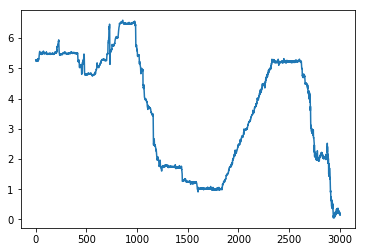

In [31]:
monthly_yields = pd.read_csv("interest_rates.csv")
monthly_yields = pd.Series.dropna(monthly_yields["NFCP_M1"])
monthly_yields = monthly_yields.values
plt.plot(monthly_yields)

In [3]:
def simulate_euler_CIR(kappa, theta, sigma2, nsteps):
    dt = 1/250.0
    rates = np.zeros(nsteps)
    rates[0] = theta
    noise = np.random.normal(0, np.sqrt(dt), size=nsteps)
    for t in range(1, nsteps):
        rates[t] = abs(rates[t-1] + kappa*(theta - rates[t-1])*dt + np.sqrt(sigma2*rates[t-1])*noise[t])
    return rates

In [4]:
rates = simulate_euler_CIR(kappa=0.234, theta=0.081, sigma2=0.0073, nsteps=100000)

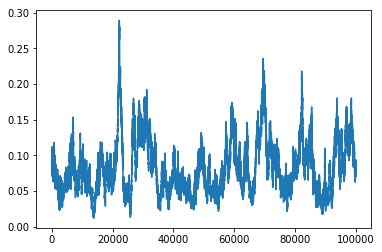

In [6]:
plt.plot(rates)

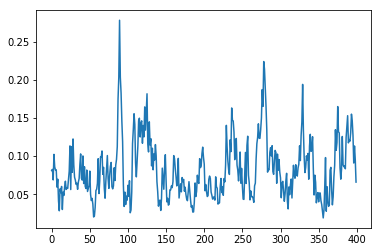

In [130]:
cir_values = rates[::250]
plt.plot(cir_values)

$$\epsilon_{k+1} - E{\epsilon_{k+1}|F_k} = 0$$
$$r_{k+1} - r_k - \kappa(\theta - r_t) \delta_k = 0$$

In [630]:
# define moment functions

def g1(pv, data, dt=1):
    theta, kappa, sig = pv
    return data[1:] - data[:-1] - kappa*(theta - data[:-1])*dt

def g2(pv, data, dt=1):
    theta, kappa, sig = pv
    return data[:-1]*g1(pv, data)

def g3(pv, data, dt=1):
    theta, kappa, sig = pv
    return (g1(pv, data))**2 - (sig**2)*data[:-1]*dt

def g4(pv, data, dt=1):
    theta, kappa, sig = pv
    return data[:-1] * g3(pv, data) - (sig**2)*(data[:-1]**2)*dt

In [638]:
def GMM(moments, param_vect, data, n_iter=1, T = 400):
    results = []
    W = np.eye(len(moments))
    
    def G(W):
        def inner(pv):
            moment_means = np.mean(np.array([g(pv, data) for g in moments]), axis=1)
            retval = moment_means @ W @ moment_means
            return retval
        return inner
    
    res = optimize.minimize(G(W), x0 = param_vect, method = 'L-BFGS-B', tol = 1.e-9, options={"maxiter":1e8},
                                bounds = [(0, np.inf), (0, np.inf), (0, np.inf)])
    
    res = res.x
    results.append(res.copy())
    for _ in range(n_iter):
        
        S = np.zeros_like(W)
        for t in range(data.shape[0]-1):
            moments_t = np.array([g(res, data[t:t+2]) for g in moments])
            
            S += np.outer(moments_t, moments_t)
        S /= (data.shape[0]-1)
        moment_means = np.array([np.mean(g(res, data)) for g in moments])
        S -= np.outer(moment_means, moment_means)
        W = np.linalg.inv(S)
        res = optimize.minimize(G(W), x0 = param_vect, method = 'L-BFGS-B', tol = 1.e-9, options={"maxiter":1e8},
                                bounds = [(0, np.inf), (0, np.inf), (0, np.inf)])
        
        res=res.x
        gmm_hess = nd.Hessian(G(W))(res)
        results.append(res.copy())
    print("RESULTS:\nParameter Estimates:\n First Iteration:")
    print(results[0])
    print("\n Second Iteration:\n")
    print(results[1])
    print("\n Covariance Matrix:")
    print(inv(gmm_hess))
    print("\n Standard Error of Estimates")
    print(np.sqrt(np.diag(inv(gmm_hess)) / T))

In [635]:
# applying GMM to the CIR simulation

theta_init = np.mean(monthly_rates)
kappa_init = 0.1 #0.234
sig2_init = 0.1 #0.0073
opt_input = [theta_init, kappa_init, sig2_init]

In [636]:
GMM([g1, g2, g3, g4], opt_input, monthly_rates, n_iter=1, T = 400)


RESULTS:
Parameter Estimates:
 First Iteration:
[0.08234848 0.10000023 0.09998909]

 Second Iteration:

[0.08142463 0.13463728 0.06584255]

 Covariance Matrix:
[[ 0.0098807  -0.01791844  0.00115358]
 [-0.01791844  0.21041337 -0.00720081]
 [ 0.00115358 -0.00720081  0.00212036]]

 Standard Error of Estimates
[0.0002776  0.00081629 0.00014094]


In [642]:
# now try with tbill data
opt_input = [np.mean(monthly_yields), 1.65e-3, 2.7e-4]   # we see an unfortunate collapse in the second and third
                                                         # parameters after the first update of the weighing matrix.
results = GMM([g1, g2, g3, g4], opt_input, monthly_yields, n_iter=1, T = 3004)  # we also see that the estimated 
                                                             #covariance is useless because it is not positive semidef
results                                                             

RESULTS:
Parameter Estimates:
 First Iteration:
[3.69949847e+00 1.65707611e-03 1.65647105e-02]

 Second Iteration:

[3.70295034 0.         0.        ]

 Covariance Matrix:
[[-2.35650669e+03 -7.80048895e-01  0.00000000e+00]
 [-7.80048895e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.11160676e-03]]

 Standard Error of Estimates
[       nan 0.         0.00164325]


## Using Quasi-Maximum Likelihood

In [608]:
def QML_G(data):
    def qml(pv):
        theta, kappa, sig = pv
        lik = 0
        for i in range(data.shape[0]-1):
            lik += norm.logpdf(data[i + 1], data[i] + kappa*(theta - data[i]), 
                        np.sqrt(sig**2 * data[i]))
        return -lik
    return qml

In [609]:
# Applying QML to the CIR simulation
qml_cir = optimize.minimize(QML_G(cir_values), 
                  x0 = [np.mean(cir_values), 0.1, 0.1])
qml_cir.x   # Parameter Estimates: result looks good, close to actual values (the third parameter squared is sig2^hat)

array([ 0.08220547,  0.19654241, -0.07686952])

In [611]:
cir_qml_covarmat = qml_cir.hess_inv   # covariance matrix is the inverse hessian
cir_qml_covarmat

array([[ 3.08253303e-05, -7.49661069e-05, -2.04078177e-08],
       [-7.49661069e-05,  2.66529694e-04, -4.71332156e-06],
       [-2.04078177e-08, -4.71332156e-06,  7.94585725e-06]])

In [612]:
# Standard Error of estimates
cir_qml_semat = np.sqrt(np.diag(qml_cir.hess_inv) / 400)  # T = 400
cir_qml_semat

array([0.0002776 , 0.00081629, 0.00014094])

In [613]:
## Applying QML to yield data

qml_yield = optimize.minimize(QML_G(monthly_yields), x0 = [np.mean(monthly_yields), 0.1, 0.1])  
qml_yield.x

array([2.65813478e+00, 1.64124146e-03, 3.86639902e-02])

In [614]:
yield_qml_covarmat = qml_yield.hess_inv   # covariance matrix is the inverse hessian
yield_qml_covarmat

array([[ 3.15341183e-01, -9.39807905e-05,  6.81940274e-06],
       [-9.39807905e-05,  2.90300302e-07, -3.33467557e-08],
       [ 6.81940274e-06, -3.33467557e-08,  2.55201717e-07]])

In [615]:
# Standard Error of estimates
yield_qml_semat = np.sqrt(np.diag(yield_qml_covarmat) / 3004)  # T = 3004
yield_qml_semat

array([1.02456704e-02, 9.83045863e-06, 9.21704763e-06])

###  Shoji Ozaki Estimation

In [423]:
def SO_lik(yts):
    def like(pv):
        theta, kappa, sig = pv
        dt = 1
        A = (2/yts[:-1])*(kappa*theta - (sig**2)/4) - kappa*(yts[:-1])/2 
        B = (-2/(yts[:-1]**2)) * (kappa*theta - (sig**2)/4) - kappa/2
        C = (4/(yts[:-1]**3)) * (kappa*theta - (sig**2)/4)

        K = np.exp(B*dt) - 1

        M = yts[:-1] + (A/B)*K + ((sig**2) * C)/(2 * (B**2))*(K - B*dt)
        V = (sig**2)/(2*B) * (np.exp(2*B*dt) - 1)

        lik = 0
        for i in range(yts.shape[0] -1):
            lik -= -((yts[i + 1] - M[i])**2) / (2*V[i]) - (1/2)*np.log(2*np.pi*V[i])
        return lik
    return like

In [287]:
# applying the SO method to our CIR data

yts = 2 * np.sqrt(monthly_rates)
SO_cir = optimize.minimize(SO_lik(yts), x0 = [np.mean(cir_values), 0.1, 0.1], tol = 1.e-14) 
SO_cir.x # estimates look good (third parameter is squared by the likelihood function, so sig2^hat = 0.0073)

array([ 0.08207893,  0.23180038, -0.08533581])

In [295]:
# Covariance Matrix of estimates
SO_cir_covmat = SO_cir.hess_inv
SO_cir_covmat

array([[6.15068868e-07, 2.75964115e-07, 4.77048612e-07],
       [2.75964115e-07, 1.25415658e-07, 2.13329046e-07],
       [4.77048612e-07, 2.13329046e-07, 3.70387727e-07]])

In [297]:
# Standard Error of Estimates
SO_cirse = np.sqrt(np.diag(SO_cir_covmat) / 400)  # T = 400
SO_cirse

array([3.92131632e-05, 1.77070366e-05, 3.04297440e-05])

In [597]:
# applying the SO method to the yield data
yts2 = 2 * np.sqrt(monthly_yields)
res = optimize.minimize(SO_lik(yts2), x0 = [np.mean(monthly_yields), 3e-4, 1.5e-2],  
                        bounds = [(0, np.Inf), (0.0, np.Inf), (0.0, np.Inf)], method = "SLSQP",
                  options={"maxiter":1e8}, 
                   tol = 1.e-16)

In [598]:
print(res.x)  # parameter estimates seem reasonable

[4.95481454e+00 2.55076826e-03 1.01681261e-01]


In [599]:
H = nd.Hessian(SO_lik(yts2))([3.69906711, 0.03086127, 0.05844546])

In [600]:
SO_covmat = inv(nd.Hessian(SO_lik(yts2))(res.x))
SO_covmat

array([[-1.39327912e+00,  9.88757349e-04, -6.45776022e-03],
       [ 9.88757349e-04, -5.95237524e-07, -2.11562824e-06],
       [-6.45776022e-03, -2.11562824e-06, -1.36627118e-04]])

In [410]:
SO_se = np.sqrt(np.diag(SO_covmat) / 3004)
SO_se

array([0.00166578,        nan, 0.00013013])

### Using Exact Likelihood

In [382]:
#4. Exact Likelihood
def exact_lik(xts):
    def e_like(pv):
        theta = pv[0]
        kappa = pv[1]
        sig = pv[2]
        dt = 1 # set dt = 1000 for monthly_yields
        lik = 0
    
        c = (2 * kappa) / ((sig**2) * (1 - np.exp(-kappa * dt)) )
        u = c * xts * np.exp(-kappa * dt)
        v = c * xts

        q = (2 * kappa * theta) / (sig**2) - 1
     
        for i in range(xts.shape[0] -1):
            #print(special.iv(q, 2*np.sqrt(u[i] * v[i + 1])))
            lik += np.log(c * np.exp(-(u[i] + v[i + 1])) * (v[i + 1] / u[i])**(q / 2) 
                    * special.iv(q, 2*np.sqrt(u[i] * v[i + 1])))
        return -lik
    return e_like

In [378]:
# using exact likelihood on our CIR data

el_cir = optimize.minimize(exact_lik(cir_values), x0 = [0.1, 0.1, 0.1],
                 tol = 1.e-14)  # looks good: third parameter is sig^hat, so sig2^hat is about 0.07

In [379]:
el_cir.x # looks good: third parameter is sig^hat, so sig2^hat is about 0.007

array([0.0822158 , 0.23273283, 0.08544394])

In [380]:
el_covmat = el_cir.hess_inv
el_covmat

array([[ 1.25844977e-04, -7.39392537e-05,  1.30561110e-06],
       [-7.39392537e-05,  4.74458309e-05,  1.26088187e-06],
       [ 1.30561110e-06,  1.26088187e-06,  9.48667832e-06]])

In [381]:
el_se = np.sqrt(np.diag(el_covmat) / 400)
el_se

array([0.0005609, 0.0003444, 0.000154 ])

In [602]:
# applying exact likelihood to monthly yields
# note that dt was set to 1000

res = optimize.minimize(exact_lik(monthly_yields), x0 = [0.1, 0.1, 0.1], bounds = [(0.0, 4), (0.001, 1), (1e-15, 1)], 
                  tol = 1.e-14)
# divide parameters to account for dt = 1000
print(np.array([res.x[0], res.x[1] / 1000, res.x[2] / np.sqrt(1000)]))  # seems encouraging: first value is very
                                                        # close to sample mean despite its initial value of 0.1

[3.69926439e+00 2.93940416e-04 2.93625801e-02]


In [604]:
el_yield_hess = nd.Hessian(exact_lik(monthly_yields))(res.x)
el_yield_covmat = inv(nd.Hessian(exact_lik(monthly_yields))(res.x))

# divide by scaling factors since dt = 1000
el_yield_covmat[0][2] /= 1000
el_yield_covmat[2][0] /= 1000
el_yield_covmat[1][1] /= (1000**2)
el_yield_covmat[1][2] /= (1000**(3/2))
el_yield_covmat[2][1] /= (1000**(3/2))
el_yield_covmat[2][2] /= 1000
el_yield_covmat

In [607]:
el_yield_se = np.sqrt(np.diag(el_yield_covmat) / 3001)
el_yield_se

array([0.00077588, 0.00034856, 0.01740926])